In [1]:
from functools import reduce
import glob
import os
import random
import time

import dask
import dask.array as da
from dask.distributed import Client, LocalCluster
import numpy as np

from app.commons.histogram import calculate_histogram, combine_histogram, flatten, save_histogram
from app.commons.increment import increment, dump
from app.commons.kmeans import classify_block, dump
from app.utils import load

# Rename function
def read(*args, **kwargs):
    return load(*args, **kwargs)
def write(*args, **kwargs):
    return dump(*args, **kwargs)

In [2]:
client = Client(LocalCluster())
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 62.82 GiB
Comm: tcp://127.0.0.1:46339,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 62.82 GiB
Comm: tcp://127.0.0.1:45945,Total threads: 4
Dashboard: http://127.0.0.1:38401/status,Memory: 10.47 GiB
Nanny: tcp://127.0.0.1:36975,


In [3]:
common_args = {
    "benchmark_folder": "",
    "start": 0,
    "output_folder": "",
    "experiment": "app-viz",
}

In [6]:
input_folder = os.path.join(os.path.expanduser("~"), "datasets", "bigbrain", "nii", "sample-3")
output_folder = os.path.join(os.path.expanduser("~"), "datasets", "bigbrain", "nii", "sample-3-output")
common_args["output_folder"] = output_folder

iterations = 3
delay = 0.1
seed = 1234

# Increment

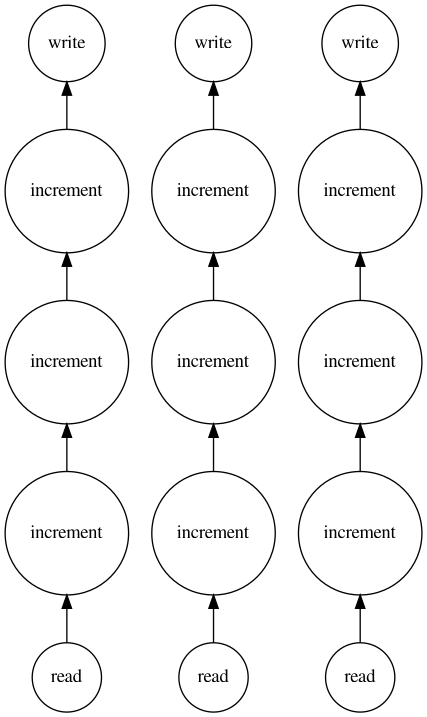

In [5]:
blocks = [
    dask.delayed(read)(
        filename,
        **common_args,
    )
    for filename in glob.glob(input_folder + "/*.nii")
]

results = []
for block in blocks:
    for _ in range(iterations):
        block = dask.delayed(increment)(
            block,
            delay=delay,
            **common_args,
        )

    results.append(
        dask.delayed(write)(
            block,
            **common_args,
        )
    )

dask.visualize(results, filename="../latex/figures/increment.png", collapse_outputs=True,)

# Histogram

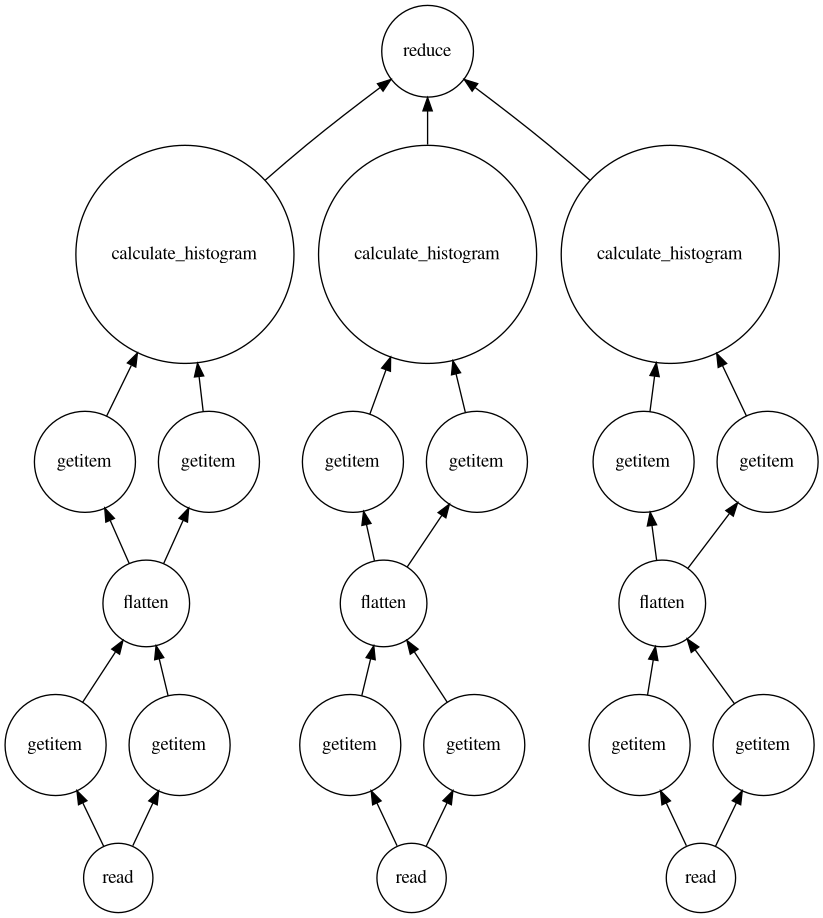

In [6]:
blocks = [
        dask.delayed(read)(
            filename,
            **common_args,
        )
        for filename in glob.glob(input_folder + "/*.nii")
    ]

partial_histogram = []
for block in blocks:
    img = dask.delayed(flatten)(
        block[1],
        **common_args,
        filename=block[0],
    )

    partial_histogram.append(
        dask.delayed(calculate_histogram)(
            img[1],
            **common_args,
            filename=img[0],
        )
    )

histogram = dask.delayed(reduce)(
    lambda x, y: combine_histogram(
        x,
        y,
        **common_args,
    ),
    partial_histogram,
)

dask.visualize(histogram, filename="../latex/figures/histogram.png", collapse_outputs=True,)

# Multi-increment

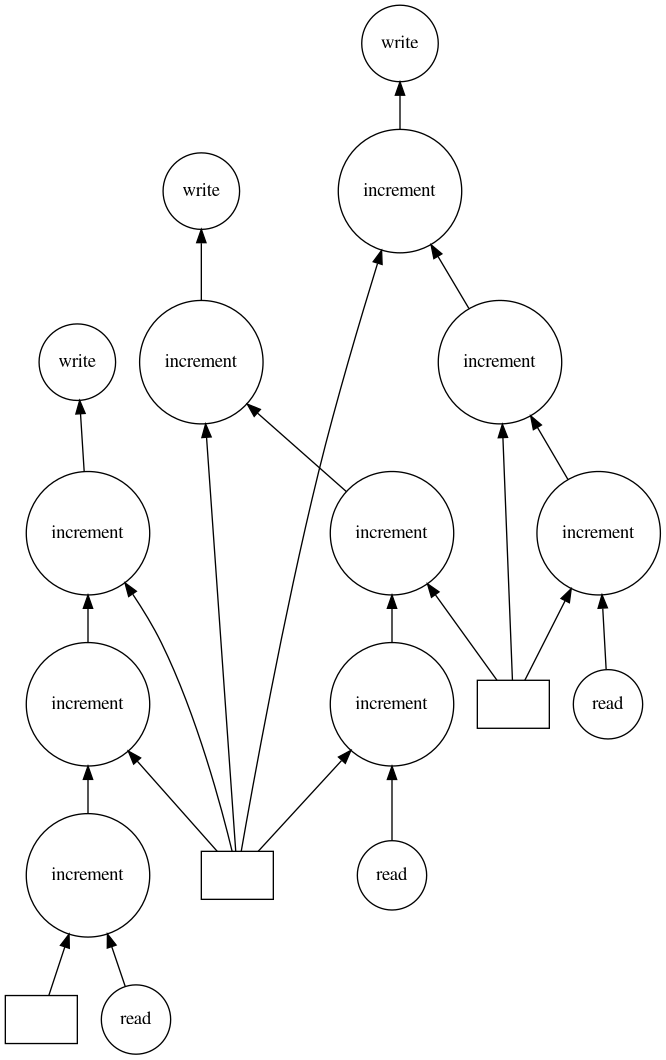

In [7]:
blocks = [
    dask.delayed(read)(
        filename,
        **common_args,
    )
    for filename in glob.glob(input_folder + "/*.nii")
]

results = []
random.seed(seed)
for block in blocks:
    for _ in range(iterations):
        block = dask.delayed(increment)(
            block,
            delay=delay,
            increment_data=random.choice(blocks)[1].persist(),
            **common_args,
        )

    results.append(
        dask.delayed(write)(
            block,
            **common_args,
        )
    )
    
dask.visualize(results, filename="../latex/figures/multi-increment.png", collapse_outputs=True)

# Kmeans (Dask)

In [21]:
import numba


@numba.njit(nogil=True, fastmath=True)
def _centers_dense(X, labels, n_clusters, *, benchmark_folder, start, experiment, output_folder):
    centers = np.zeros(
        (n_clusters, 2),
        dtype=np.uint16,
    )

    for i in range(X.shape[0]):
        centers[labels[i], 0] += X[i]
        centers[labels[i], 1] += 1

    return centers

def get_labels(X, centroids, *, benchmark_folder, start, experiment, **kwargs):
    array = np.subtract.outer(X, centroids)
    np.square(array, out=array)
    return np.argmin(array, axis=1)

In [22]:
blocks = [
dask.delayed(load)(
        filename,
        **common_args,
    )
    for filename in glob.glob(input_folder + "/*.nii")
]

sample = blocks[0].compute()[1]  # Compute a sample block to obtain dtype and shape.
dtype = sample.dtype

voxels = (
    da.stack(
        [
            da.from_delayed(block[1], dtype=dtype, shape=sample.shape)
            for block in blocks
        ],
    )
    .reshape(-1)
    .rechunk(block_size_limit=64 * 1024 ** 2)  # 128MB chunks
)

n_clusters = 3
centroids = np.linspace(
    da.min(voxels).compute(),
    da.max(voxels).compute(),
    num=n_clusters,
)
print(centroids)

labels = None
for _ in range(iterations):  # Disregard convergence.

    labels = da.map_blocks(
        lambda X: get_labels(X, centroids, **common_args),
        voxels,
        dtype=np.ubyte,
    )
    labels.compute()

    # Ref: from dask_ml.cluster.k_means::_kmeans_single_lloyd
    r = da.blockwise(
        _centers_dense,
        "ik",
        voxels,
        "i",
        labels,
        "i",
        n_clusters,
        None,
        **common_args,
        new_axes={"k": 2},
        dtype=voxels.dtype,
    )
    centers_meta = np.sum(dask.compute(*r.to_delayed().flatten()), axis=0)
    new_centers = centers_meta[:, 0]
    counts = centers_meta[:, 1]
    counts = np.maximum(counts, 1, out=counts)
    centroids = new_centers / counts
    print(centroids)

[    0. 31429. 62858.]
[  0.96354267   1.26375532 152.96453901]
[7.10036878e-04 9.83181305e+00 4.67063749e-01]
[0.         0.75487204 3.17050691]


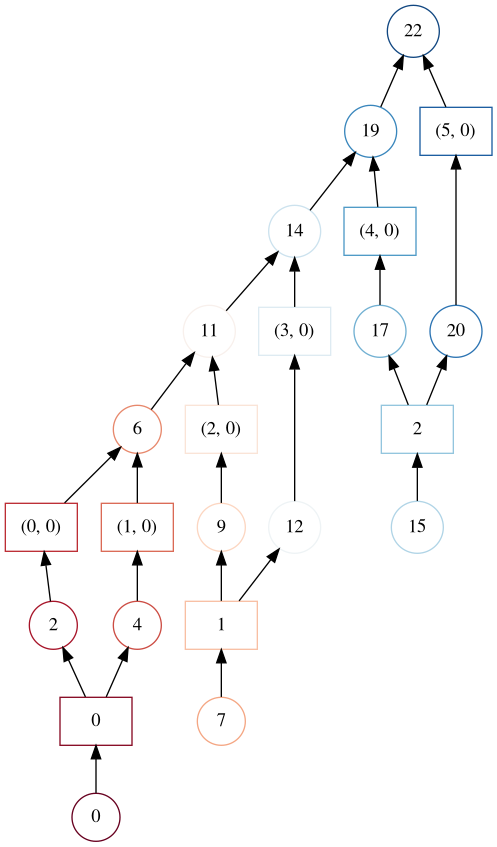

In [22]:
dask.visualize(
    r.to_delayed().sum(),
    color="order",
    collapse_outputs=True
)

# Kmeans (Spark)

In [6]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("spark://localhost:7077").setAppName("test")
conf.set("spark.executor.memory", "48g")
conf.set("spark.driver.memory", "4g") 
conf.set("spark.driver.maxResultSize", "4g") 
sc = SparkContext.getOrCreate(conf=conf)

21/08/06 16:58:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/06 16:58:33 WARN SparkContext: Please ensure that the number of slots available on your executors is limited by the number of cores to task cpus and not another custom resource. If cores is not the limiting resource then dynamic allocation will not work properly!


In [7]:
import math
def rechunk(X: np.array, *, chunk_size: int) -> list[np.array]:
    """Chunk a NumPy array into arrays of a given maximum size.
    
    parameters
    ----------
    X: np.array
        Array to rechunk.
    chunk_size: int
        Maximum size for an array chunk in byte.
        
    returns
    -------
    list[np.array]
        Newly created chunks from original array.
    """
    n_chunks = math.ceil(X.itemsize * X.size / chunk_size)
    return np.array_split(X, n_chunks)

In [8]:
files = glob.glob(input_folder + "/*.nii")
paths = sc.parallelize(files, len(files))
blocks = paths.map(lambda p: load(p, **common_args))
voxels = blocks.flatMap(lambda block: rechunk(block[1].flatten(), chunk_size=1e7))
voxels = voxels.repartition(voxels.count()).cache()

n_clusters = 3
centroids = np.linspace(
    voxels.flatMap(lambda x: x).min(),
    voxels.flatMap(lambda x: x).max(),
    num=n_clusters,
)
print(centroids)

for _ in range(iterations):  # Disregard convergence.

    labels = voxels.map(lambda X: get_labels(X, centroids))
    r = voxels.zip(labels).map(lambda x: _centers_dense(x[0], x[1], n_clusters))
    centers_meta = np.array(r.collect()).sum(axis=0)
    new_centers = centers_meta[:, 0]
    counts = centers_meta[:, 1]
    counts = np.maximum(counts, 1, out=counts)
    centroids = new_centers / counts

    print(centroids)

[    0.  32767.5 65535. ]


[0.23632142 1.09392912 3.76623114]


[0.         1.54353685 1.03888923]


[0.         1.03967459 1.        ]
